#Import Library

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
from tqdm import tqdm
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

#Import Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abnadzirinsabilan","key":"879b3ce5751d1f4ba88d3fc41c571a00"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 89% 212M/239M [00:00<00:00, 719MB/s] 
100% 239M/239M [00:00<00:00, 768MB/s]


## Unzip Dataset

In [ ]:
!unzip garbage-classification.zip -d garbage_dataset

Streaming output truncated to the last 5000 lines.
  inflating: garbage_dataset/garbage_classification/paper/paper381.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper382.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper383.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper384.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper385.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper386.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper387.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper388.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper389.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper39.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper390.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper391.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper392.jpg  
 

# Load Data

In [ ]:
base_dir = '/content/garbage_dataset/garbage_classification'
folders = os.listdir(base_dir)
print("Kelas dalam dataset:")
print(folders)

Kelas dalam dataset:
['clothes', 'paper', 'plastic', 'battery', 'cardboard', 'brown-glass', 'shoes', 'biological', 'green-glass', 'white-glass', 'metal', 'trash']


In [ ]:
for folder in folders:
  folder_path = os.path.join(base_dir, folder)
  if os.path.isdir(folder_path):
    count = len(os.listdir(folder_path))
    print(f"{folder}: {count}")

clothes: 5325
paper: 1050
plastic: 865
battery: 945
cardboard: 891
brown-glass: 607
shoes: 1977
biological: 985
green-glass: 629
white-glass: 775
metal: 769
trash: 697


# Data Preparation

## Rename kolom

In [ ]:
trash_path = os.path.join(base_dir, 'trash')
dangerous_trash_path = os.path.join(base_dir, 'dangerous_trash')
os.rename(trash_path, dangerous_trash_path)

folders = os.listdir(base_dir)
print("Kelas dalam dataset setelah rename:")
print(folders)
for folder in folders:
  folder_path = os.path.join(base_dir, folder)
  if os.path.isdir(folder_path):
    count = len(os.listdir(folder_path))
    print(f"{folder}: {count}")

Kelas dalam dataset setelah rename:
['clothes', 'paper', 'plastic', 'battery', 'cardboard', 'brown-glass', 'shoes', 'biological', 'green-glass', 'dangerous_trash', 'white-glass', 'metal']
clothes: 5325
paper: 1050
plastic: 865
battery: 945
cardboard: 891
brown-glass: 607
shoes: 1977
biological: 985
green-glass: 629
dangerous_trash: 697
white-glass: 775
metal: 769


## Menampilkan sample dari setiap kelas

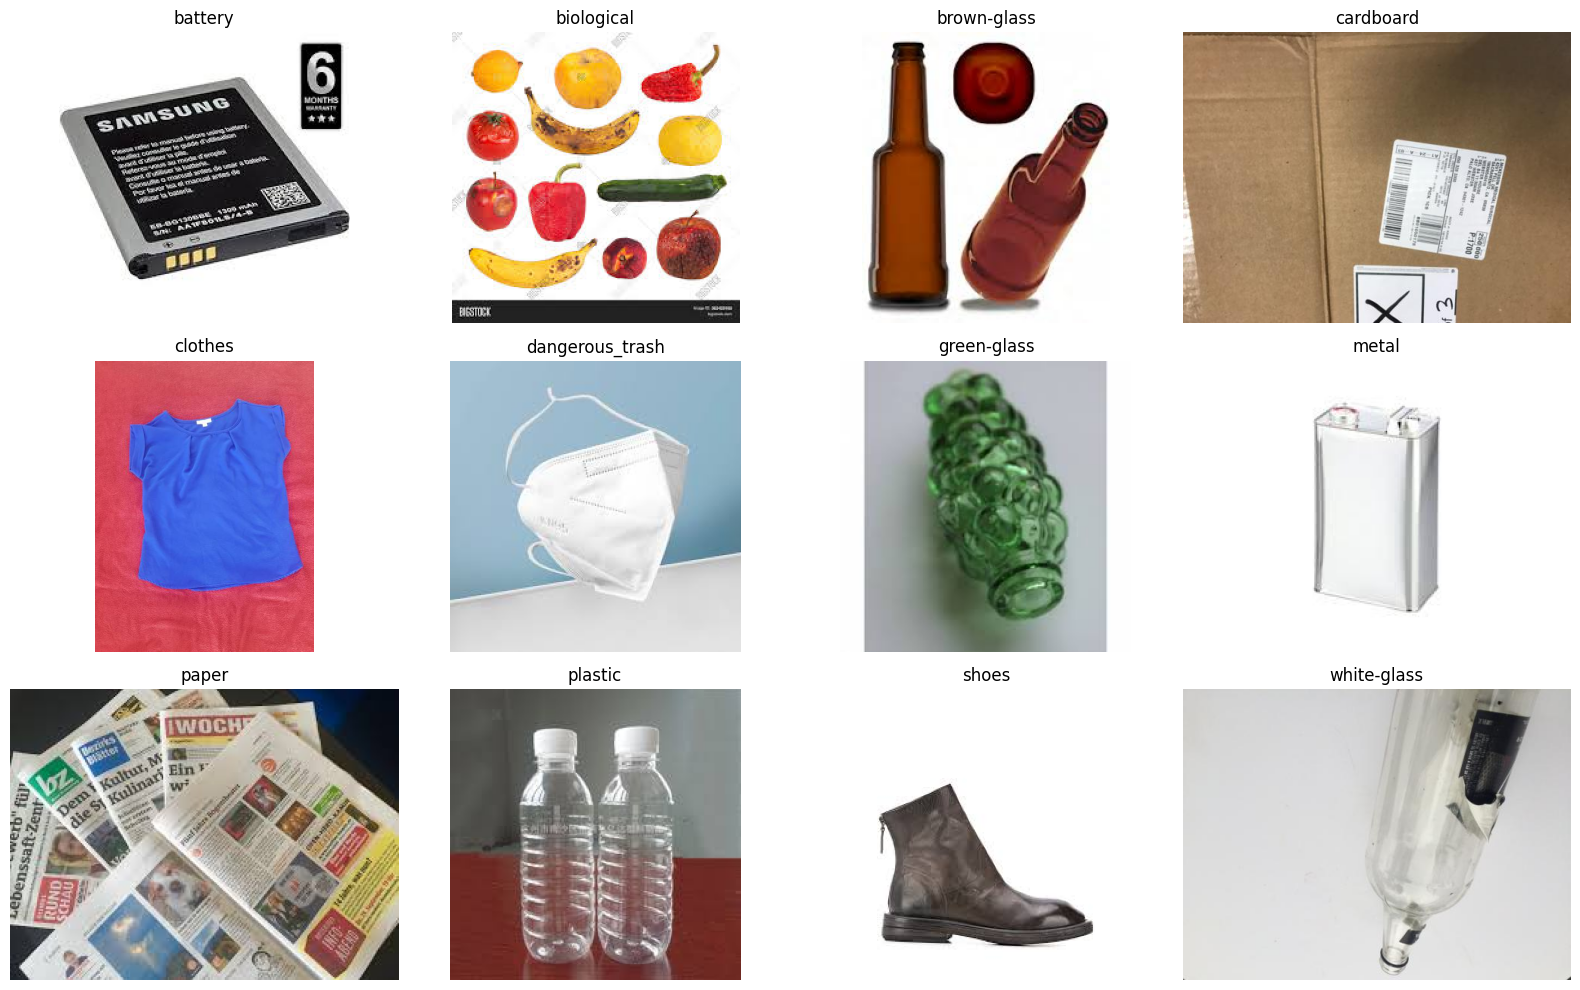

In [ ]:
base_dir = '/content/garbage_dataset/garbage_classification'
kelas = os.listdir(base_dir)

plt.figure(figsize=(16, 10))

for i, nama_kelas in enumerate(sorted(kelas)):
    folder_path = os.path.join(base_dir, nama_kelas)
    if os.path.isdir(folder_path):
        gambar_list = os.listdir(folder_path)
        gambar_acak = random.choice(gambar_list)
        gambar_path = os.path.join(folder_path, gambar_acak)

        img = Image.open(gambar_path)

        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(nama_kelas)
        plt.axis('off')

plt.tight_layout()
plt.show()

## Mapping dari 12 kelas menjadi 3 kelas

In [ ]:
# Path asal dataset
src_dir = '/content/garbage_dataset/garbage_classification'

# Path tujuan dataset setelah mapping dan split
dst_dir = '/content/dataset_sampah'

# Mapping dari 12 kelas → 3 kelas
mapping = {
    'biological': 'organik',
    'battery': 'b3',
    'dangerous_trash': 'b3',
    'metal': 'non-organik',
    'green-glass': 'non-organik',
    'white-glass': 'non-organik',
    'brown-glass': 'non-organik',
    'plastic': 'non-organik',
    'cardboard': 'non-organik',
    'paper': 'non-organik',
    'clothes': 'non-organik',
    'shoes': 'non-organik',
}

# Buat struktur direktori baru
for split in ['train', 'val', 'test']:
    for label in ['organik', 'non-organik', 'b3']:
        os.makedirs(os.path.join(dst_dir, split, label), exist_ok=True)


## Split Dataset

In [ ]:
# Rasio pembagian
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1


for kelas_asal in tqdm(mapping.keys(), desc='Proses mapping dan split'):
    label_baru = mapping[kelas_asal]
    folder_asal = os.path.join(src_dir, kelas_asal)
    semua_file = os.listdir(folder_asal)
    random.shuffle(semua_file)

    total = len(semua_file)
    train_count = int(train_ratio * total)
    val_count = int(val_ratio * total)

    train_files = semua_file[:train_count]
    val_files = semua_file[train_count:train_count + val_count]
    test_files = semua_file[train_count + val_count:]

    def salin(files, split):
        for nama_file in files:
            src_file = os.path.join(folder_asal, nama_file)
            dst_folder = os.path.join(dst_dir, split, label_baru)
            shutil.copy(src_file, dst_folder)

    salin(train_files, 'train')
    salin(val_files, 'val')
    salin(test_files, 'test')

Proses mapping dan split: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]


## Menampilkan jumlah gambar per kelas di masing-masing data split

In [ ]:
for split in ['train', 'val', 'test']:
    print(f"\n📁 {split.upper()}")
    for label in ['organik', 'non-organik', 'b3']:
        folder = os.path.join(dst_dir, split, label)
        count = len(os.listdir(folder))
        print(f"{label}: {count} gambar")


📁 TRAIN
organik: 788 gambar
non-organik: 10308 gambar
b3: 1313 gambar

📁 VAL
organik: 98 gambar
non-organik: 1284 gambar
b3: 163 gambar

📁 TEST
organik: 99 gambar
non-organik: 1296 gambar
b3: 166 gambar


## Augmentasi Data

In [ ]:
dataset_dir = '/content/dataset_sampah'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    dataset_dir + '/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    dataset_dir + '/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 12409 images belonging to 3 classes.
Found 1545 images belonging to 3 classes.
Found 1561 images belonging to 3 classes.


# Modeling

## Membuat arsitektur Model CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas output
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Melatih model

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 91s 219ms/step - accuracy: 0.8334 - loss: 0.5459 - val_accuracy: 0.8440 - val_loss: 0.3807
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 79s 203ms/step - accuracy: 0.8334 - loss: 0.4109 - val_accuracy: 0.8570 - val_loss: 0.4186
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 78s 200ms/step - accuracy: 0.8447 - loss: 0.3836 - val_accuracy: 0.8712 - val_loss: 0.3266
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 78s 201ms/step - accuracy: 0.8565 - loss: 0.3644 - val_accuracy: 0.8693 - val_loss: 0.3387
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 78s 201ms/step - accuracy: 0.8649 - loss: 0.3302 - val_accuracy: 0.8777 - val_loss: 0.3143
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 77s 199ms/step - accuracy: 0.8708 - loss: 0.3240 - val_accuracy: 0.8803 - val_loss: 0.3212
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 79s 203ms/step - accuracy: 0.8695 - loss: 0.3297 - val_accuracy: 0.8667 - val_loss: 0.3526
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 77s 199ms/step - accuracy: 0.8736 - loss: 0

# Evaluation

In [ ]:
results = model.evaluate(test_generator)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8392 - loss: 0.3720
Test Loss: 0.2433735728263855
Test Accuracy: 0.9071108102798462
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

Classification Report:
              precision    recall  f1-score   support

          b3       0.83      0.52      0.64       166
 non-organik       0.92      0.97      0.95      1296
     organik       0.80      0.70      0.75        99

    accuracy                           0.91      1561
   macro avg       0.85      0.73      0.78      1561
weighted avg       0.90      0.91      0.90      1561


Confusion Matrix:
[[  86   80    0]
 [  18 1261   17]
 [   0   30   69]]


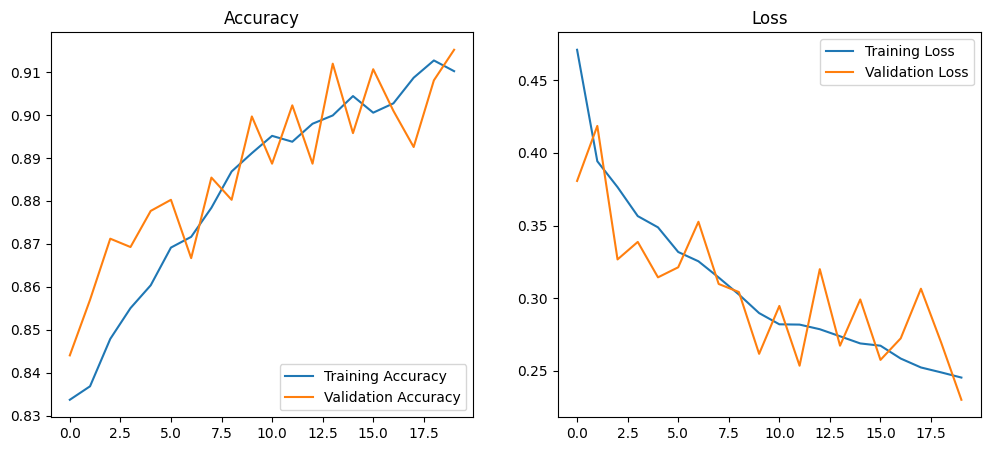

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

# Eksport Model

In [ ]:
model.export('saved_model/')

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136511835456720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511824903824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511824903440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511835466704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511824903056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511824904016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511835466320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511827478096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511827478480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136511827480016: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
os.makedirs('tflite', exist_ok=True)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
labels = ['organik', 'non-organik', 'b3']
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!mkdir -p tfjs_model
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-05-21 12:48:27.953475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747831707.972772    7636 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747831707.978661    7636 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-21 12:48:33.710627: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747831713.710824    7636 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!zip -r saved_model.zip saved_model/
!zip -r tflite.zip tflite/
!zip -r tfjs_model.zip tfjs_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 62%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: saved_model/saved_model.pb (deflated 85%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: tflite/label.txt (deflated 17%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 88%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)


# Inference model

In [ ]:
import io #mengimport secara eksplisit

def predict_uploaded_image(model):
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Memuat gambar
        img = Image.open(io.BytesIO(uploaded[fn])).resize((150, 150))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 # Normalisasi seperti data training

        # Melakukan prediksi
        predictions = model.predict(img_array)

        # Menampilkan hasil prediksi
        predicted_class_index = np.argmax(predictions)
        confidence = np.max(predictions) * 100

        # Mendapatkan nama kelas dari generator (sesuai urutan)
        class_indices = train_generator.class_indices
        # Membalik dictionary untuk mendapatkan nama kelas dari index
        idx_to_class = dict((v, k) for k, v in class_indices.items())
        predicted_class_label = idx_to_class[predicted_class_index]

        print(f"Gambar: {fn}")
        print(f"Prediksi: {predicted_class_label}")
        print(f"Akurasi Prediksi: {confidence:.2f}%")

# Panggil fungsi untuk melakukan prediksi dengan gambar yang diunggah
predict_uploaded_image(model)


Saving R.jpeg to R.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Gambar: R.jpeg
Prediksi: non-organik
Akurasi Prediksi: 80.17%
